In [1]:
import networkx as nx
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

Reading in the graph

In [2]:
graph = nx.read_gml("C:/Users/lilin/Downloads/netscience/netscience.gml")

Initializing some values that are useful for multiple different plots.

In [3]:
#The number of links in the original graph.
all_links = len(graph.edges())
#The number of nodes in the giant component in the original graph.
Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
Gc = nx.Graph(graph.subgraph(Gcc[0]))
N_GC_f_0 = len(Gc.nodes())

In [4]:
print("The number of links in the original graph: ", all_links)
print("The number of nodes in the original graph: ", len(graph.nodes()))
print("The number of nodes in the giant component in the original graph: ", N_GC_f_0)
print("The number of links in the giant component in the original graph: ", len(Gc.edges()))
print("The number of components in the original graph: ", len(Gcc))
print("The number of components in the original graph: ", nx.number_connected_components(graph))


The number of links in the original graph:  2742
The number of nodes in the original graph:  1589
The number of nodes in the giant component in the original graph:  379
The number of links in the giant component in the original graph:  914
The number of components in the original graph:  396
The number of components in the original graph:  396


### Making diagram A

In [5]:
def R_GC_f_removing_links(N_GC_f_0, all_links, graph, weak, Gc_org):
    """
    A function removing the edges of a graph in a given order while tracking the relative size of its giant component and the fraction of 
    removed links. It returns two lists in a tupple, containing the list of the R_GC value after every link removal, and the f corresponding
    f values.

    :N_GC_f_0: The size of the giant component at f=0 (with zero links removed).
    :all_links: The number of links originally in the graph.
    :graph: The graph we are examining (more precisely, a deepcopy of it). 
    :weak: Boolean, True means the function should remove weak edges first, False means the opposite.
    """
    #A dictionary of the edges, with the edges as keys in ('one node', 'other node') format, and with the edge weights as values.
    link_dict = nx.get_edge_attributes(graph, "value")
    #Making a list of edges in the ascending or descending order (given by the 'weak' parameter) of their weights.
    if weak:
        sorted_links = sorted(link_dict.items(), key=lambda x:x[1])
    else:
        sorted_links = sorted(link_dict.items(), key=lambda x:x[1], reverse=True)
    #Initializing f at zero, initializing the giant component relative size and fraction of removed links lists.
    removed_links = 0
    f = removed_links/all_links
    R_GC = []
    R_GC.append(1)
    f_list = []
    f_list.append(f)
    #While the fraction of the removed weights is <1, i.e. there are links that have not been removed.
    while f<1:
        #The smallest/biggest weight link is the one at the top of the list.
        link_under_removal = sorted_links.pop(0)
        #Removing the edge from the graph.
        graph.remove_edge(str(link_under_removal[0][0]), str(link_under_removal[0][1]))
        #Increasing the number of removed links.
        removed_links += 1
        #Determining the current f, the ratio between the removed links and all links.
        f = removed_links/all_links
    
        #determining the number of nodes forming the giant component in the graph after the removal of the edge.
        Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
        Gc = graph.subgraph(Gcc[0])
        GC_actual = len(Gc.nodes())
        if f<0.4:
            if (str(link_under_removal[0][0]), str(link_under_removal[0][1])) in Gc_org.edges():
                Gc_org.remove_edge(str(link_under_removal[0][0]), str(link_under_removal[0][1]))
        #determining the current value of R_GC and storing its value along with the current f value.
        R_GC_actual = GC_actual/N_GC_f_0
        R_GC.append(R_GC_actual)
        f_list.append(f)

    return (R_GC, f_list, Gc_org)

In [6]:
#Making deep copies of the original graph.
G_a_asc = graph.copy()
G_a_desc = graph.copy()
#Calling the function
(R_GC_a_asc, f_list_a_asc, Gc_asc) = R_GC_f_removing_links(N_GC_f_0, all_links, G_a_asc, True, Gc.copy())
(R_GC_a_desc, f_list_a_desc, Gc_desc) = R_GC_f_removing_links(N_GC_f_0, all_links, G_a_desc, False, Gc.copy())
nx.write_gml(Gc_asc, "C:/Users/lilin/Downloads/netscience/giant_component_asc.gml")
nx.write_gml(Gc_desc, "C:/Users/lilin/Downloads/netscience/giant_component_desc.gml")

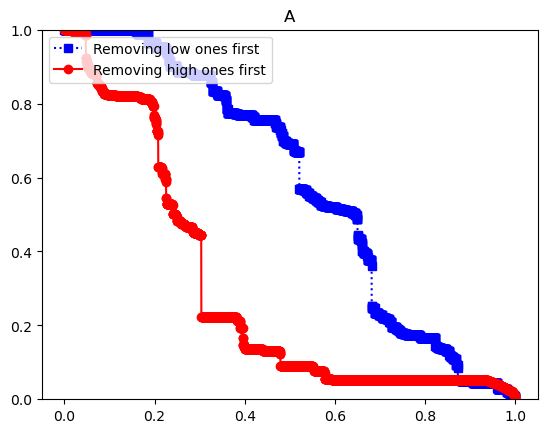

In [7]:
ax = plt.axes()
ax_asc = ax.plot(f_list_a_asc, R_GC_a_asc, 'bs:')
ax_desc = ax.plot(f_list_a_desc, R_GC_a_desc, 'ro-')  
ax.legend(labels = ('Removing low ones first',  
                    'Removing high ones first'),  
          loc = 'upper left') 
  
ax.set_title("A") 
plt.ylim((0,1))

  
plt.show()

In [8]:
df = pd.DataFrame({'f': f_list_a_asc, 'Low ones first': R_GC_a_asc,'High ones first': R_GC_a_desc})

c:\Users\lilin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


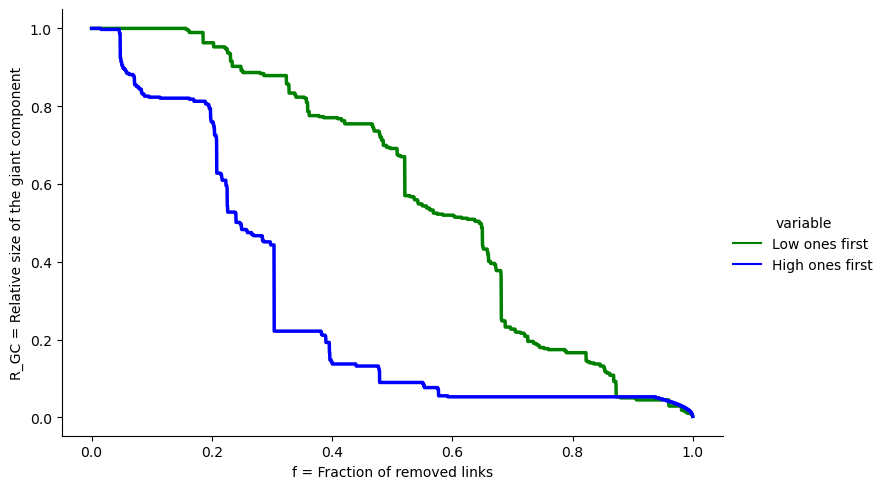

In [9]:
g = sns.relplot(data=pd.melt(df, ['f']), x="f", y="value", kind="line", hue="variable", palette=["g", "b"], linewidth=2.5, aspect=1.5)
g.set_axis_labels("f = Fraction of removed links", "R_GC = Relative size of the giant component")

c:\Users\lilin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(0.9, 1.0)

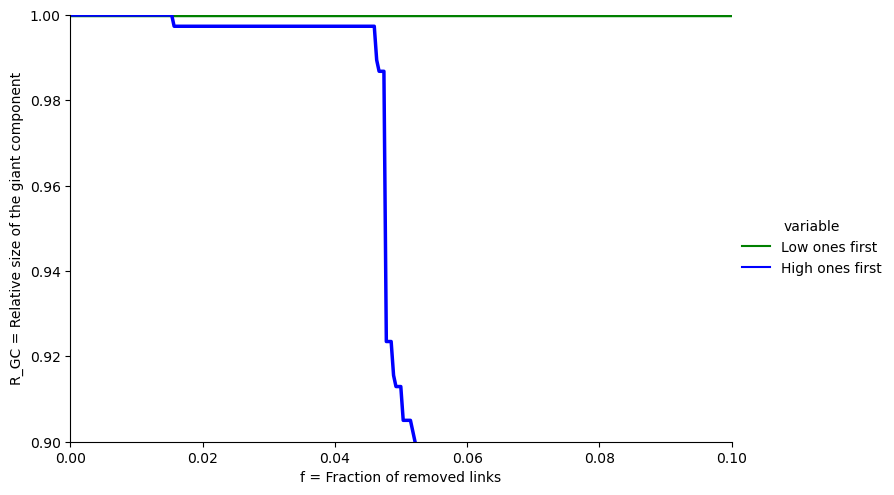

In [10]:
g = sns.relplot(data=pd.melt(df, ['f']), x="f", y="value", kind="line", hue="variable", palette=["g", "b"], linewidth=2.5, aspect=1.5)
g.set_axis_labels("f = Fraction of removed links", "R_GC = Relative size of the giant component")
plt.xlim((0,0.1))
plt.ylim((0.9, 1))

### Making diagram C

In [11]:
def calculating_S(graph):
    """
    Function calculating the S value of the graph it gets as a parameter. Returns S.
    
    """
    #Initializing a size_of_components dictionary and the S.
    size_of_components = {}
    S = 0
    #For every subgraph (except the giant component) in the graph, making a key value pair in the size_of_components dictionary with the size of the component as key
    # and 0 as value. 
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    for i in range(1, len(Gcc)):
        Gc = graph.subgraph(Gcc[i])
        num_of_nodes = len(Gc.nodes())
        size_of_components[num_of_nodes] = 0
    #For every subgraph in the graph increase the value corresponding to the key that equals the number of nodes in the subgraph by 1.
    for i in range(1, len(Gcc)):
        Gc = graph.subgraph(Gcc[i])
        num_of_nodes = len(Gc.nodes())
        size_of_components[num_of_nodes] +=1
    #The size_of_components now has the size of the component as key, and the number of components with that size as value. Summing over the
    # different sized components and multiplying the size squared by the value for each we get the S and return it.
    for key, value in size_of_components.items():
        S += (key*key*value/len(graph.nodes()))
    return S



In [12]:
def S_f_removing_links(graph, weak):
    """
    Removes the edges by order while tracking the S value of the graph.
    """
    #A dictionary of the edges, with the edges as keys in ('one node', 'other node') format, and with the edge weights as values.
    link_dict = nx.get_edge_attributes(graph, "value")
    #Making a list of edges in the ascending or descending order of their weights.
    if weak:
        sorted_links = sorted(link_dict.items(), key=lambda x:x[1])
    else:
        sorted_links = sorted(link_dict.items(), key=lambda x:x[1], reverse=True)
    #Initializing f at zero, lists of f and S.
    removed_links = 0
    f = removed_links/all_links
    S = []
    S.append(calculating_S(graph))
    f_list = []
    f_list.append(f)
    while f<1:
        #The smallest/biggest weight link is the one at the top of the list.
        link_under_removal = sorted_links.pop(0)
        #Removing the edge from the graph.
        graph.remove_edge(str(link_under_removal[0][0]), str(link_under_removal[0][1]))
        #Increasing the number of removed links.
        removed_links += 1
        #Determining the current f, the ratio between the removed links and all links.
        f = removed_links/all_links
        #Determining the S value.
        S_actual = calculating_S(graph)
        S.append(S_actual)
        f_list.append(f)

    return (S, f_list)
    


In [13]:
G_c_asc = graph.copy()
G_c_desc = graph.copy()
(S_c_asc, f_list_c_asc) = S_f_removing_links(G_c_asc, weak=True)
(S_c_desc, f_list_c_desc) = S_f_removing_links(G_c_desc, weak=False)

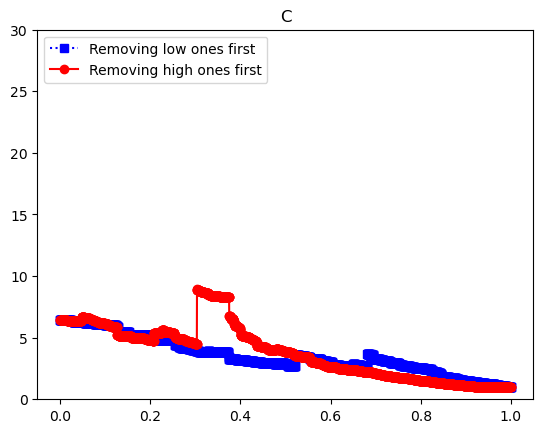

In [14]:
ax = plt.axes()
ax_asc = ax.plot(f_list_c_asc, S_c_asc, 'bs:')
ax_desc = ax.plot(f_list_c_desc, S_c_desc, 'ro-')  
ax.legend(labels = ('Removing low ones first',  
                    'Removing high ones first'),  
          loc = 'upper left') 
  
ax.set_title("C") 
plt.ylim((0,30))
  
plt.show()

In [15]:
df = pd.DataFrame({'f': f_list_c_asc, 'Low ones first': S_c_asc,'High ones first': S_c_desc})

c:\Users\lilin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(0.0, 30.0)

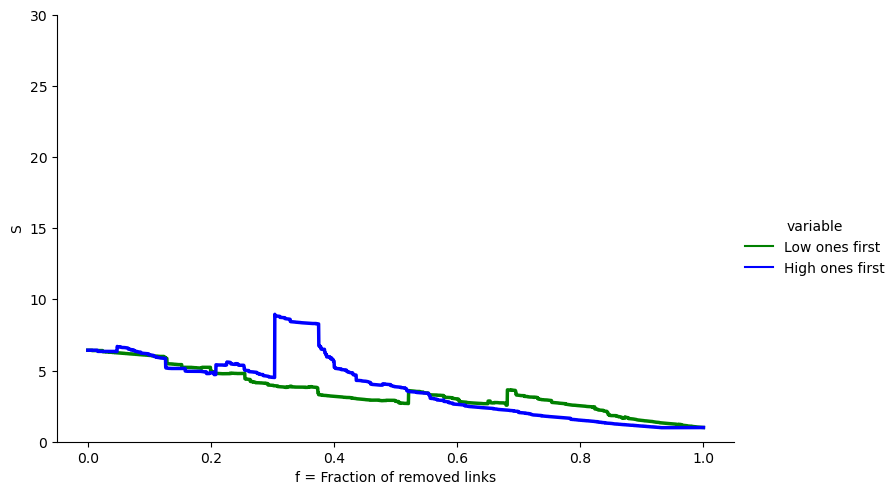

In [16]:
g = sns.relplot(data=pd.melt(df, ['f']), x="f", y="value", kind="line", hue="variable", palette=["g", "b"], linewidth=2.5, aspect=1.5)
g.set_axis_labels("f = Fraction of removed links", "S")
plt.ylim(0, 30)


### Diagram B

In [17]:
def calculate_overlap(graph):
    """
    Calculates the overlap for each edge in the graph and returns it in a dictionary.
    """
    overlap_dict = {}
    link_dict = nx.get_edge_attributes(graph, "value")
    for key in link_dict:
        node_one = str(key[0])
        node_two = str(key[1])
        one_neighbors = [n for n in graph.neighbors(node_one)]
        two_neighbors = [n for n in graph.neighbors(node_two)]
        n_i_j = 0
        #determining the number of common neighbours.
        for n in one_neighbors:
            for j in two_neighbors:
                if n==j:
                    n_i_j += 1
        #Determining the node degrees.
        k_i = graph.degree(node_one)
        k_j = graph.degree(node_two)
        #Determining the overlap.
        if n_i_j!=0:
            O_i_j = n_i_j/((k_i-1)+(k_j-1)-n_i_j)
        else:
            O_i_j = 0
        #Putting the overlap of the edge to the dictionary and returning it.
        overlap_dict[key] = O_i_j
    return overlap_dict
    

In [18]:
def R_GC_f_removing_links_O_i_j(N_GC_f_0, all_links, graph, weak):
    """
    A function removing links based on their overlap while tracking the size of the giant component.
    """
    #A dictionary of the edges, with the edges as keys in ('one node', 'other node') format, and with the overlaps as values.
    overlap_dict = calculate_overlap(graph)
    #Making a list of edges in the ascending or descending order of their overlaps.
    if weak:
        sorted_links = sorted(overlap_dict.items(), key=lambda x:x[1])
    else:
        sorted_links = sorted(overlap_dict.items(), key=lambda x:x[1], reverse=True)
    #Initializing f at zero.
    removed_links = 0
    f = removed_links/all_links
    R_GC = []
    R_GC.append(1)
    f_list = []
    f_list.append(f)
    avg_degree=[]
    avg_degree=[]
    sum = 0
    giantComp = sorted(nx.connected_components(graph), key=len, reverse=True)
    gcccc=graph.subgraph(giantComp[0])
    for node in gcccc.degree():
        sum += node[1]
    avg_degree.append(sum/len(gcccc.nodes()))
    #While the fraction of the removed weights is <1, i.e. there are links that have not been removed.
    while f<1:
        #The smallest/biggest overlap link is the one on the top of the list.
        link_under_removal = sorted_links.pop(0)
        #Removing the edge from the graph.
        graph.remove_edge(str(link_under_removal[0][0]), str(link_under_removal[0][1]))
        #Increasing the number of removed links.
        removed_links += 1
        #Determining the current f, the ratio between the removed links and all links.
        f = removed_links/all_links
        #determining the number of nodes forming the giant component in the graph after the removal of the edge.
        Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
        Gc = graph.subgraph(Gcc[0])
        GC_actual = len(Gc.nodes())
        #determining the current value of R_GC and storing its value along with the current f value.
        R_GC_actual = GC_actual/N_GC_f_0
        R_GC.append(R_GC_actual)
        f_list.append(f)
        sum = 0
        for node in Gc.degree():
            sum += node[1]
        avg_degree.append(sum/len(Gc.nodes()))

    return (R_GC, f_list, avg_degree)

In [19]:
G_b_asc = graph.copy()
G_b_desc = graph.copy()
(R_GC_asc_b, f_list_asc_b, avg_asc) = R_GC_f_removing_links_O_i_j(N_GC_f_0, all_links, G_b_asc, True)
(R_GC_desc_b, f_list_desc_b, avg_desc) = R_GC_f_removing_links_O_i_j(N_GC_f_0, all_links, G_b_desc, False)


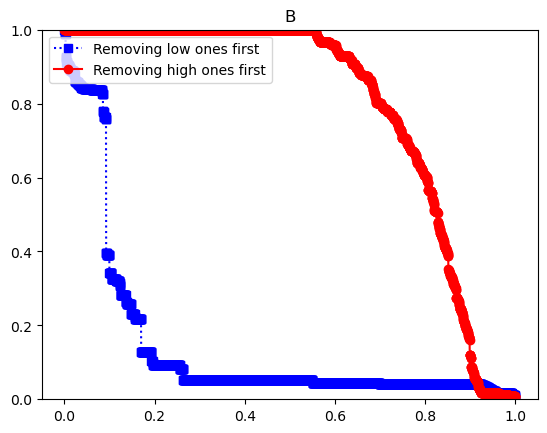

In [20]:
ax = plt.axes()
ax_asc = ax.plot(f_list_asc_b, R_GC_asc_b, 'bs:')
ax_desc = ax.plot(f_list_desc_b, R_GC_desc_b, 'ro-')  
ax.legend(labels = ('Removing low ones first',  
                    'Removing high ones first'),  
          loc = 'upper left') 
  
ax.set_title("B") 
plt.ylim((0,1))

  
plt.show()

In [21]:
df = pd.DataFrame({'f': f_list_asc_b, 'Low ones first': R_GC_asc_b,'High ones first': R_GC_desc_b})

c:\Users\lilin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(0.0, 1.0)

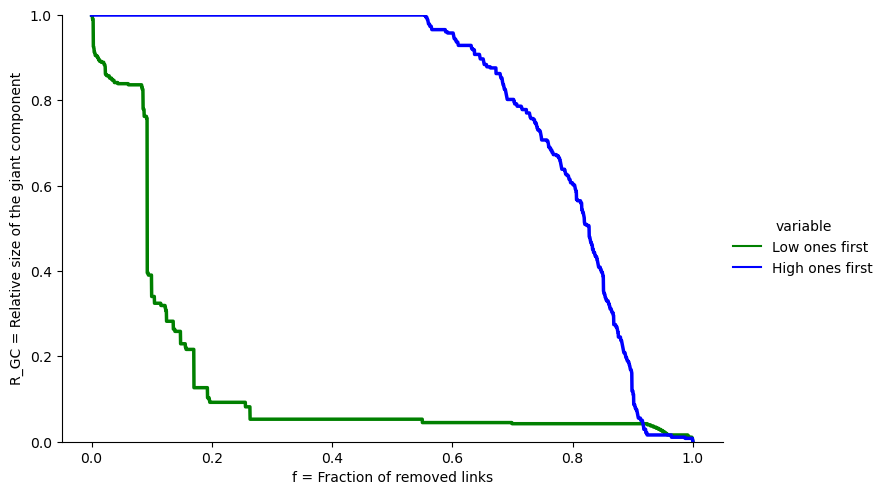

In [22]:
g = sns.relplot(data=pd.melt(df, ['f']), x="f", y="value", kind="line", hue="variable", palette=["g", "b"], linewidth=2.5, aspect=1.5)
g.set_axis_labels("f = Fraction of removed links", "R_GC = Relative size of the giant component")
plt.ylim(0, 1)


### Diagram D

In [23]:
def S_f_removing_links_O_i_j(graph, weak):
    """
    A function removing links based on their overlap while tracking the value of S.
    """
    #A dictionary of the edges, with the edges as keys in ('one node', 'other node') format, and with the overlaps as values.
    overlap_dict = calculate_overlap(graph)
    #Making a list of edges in the ascending or descending order of their overlaps.
    if weak:
        sorted_links = sorted(overlap_dict.items(), key=lambda x:x[1])
    else:
        sorted_links = sorted(overlap_dict.items(), key=lambda x:x[1], reverse=True)
    #Initializing f at zero.
    removed_links = 0
    f = removed_links/all_links
    S = []
    S.append(calculating_S(graph))
    f_list = []
    f_list.append(f)
    while f<1:
        #The smallest/biggest overlap link is the one on the top of the list.
        link_under_removal = sorted_links.pop(0)
        #Removing the edge from the graph.
        graph.remove_edge(str(link_under_removal[0][0]), str(link_under_removal[0][1]))
        #Increasing the number of removed links.
        removed_links += 1
        #Determining the current f, the ratio between the removed links and all links.
        f = removed_links/all_links
        #Determining the value of S after the removal of the edge.
        S_actual = calculating_S(graph)
        S.append(S_actual)
        f_list.append(f)

    return (S, f_list)
    

In [24]:
G_d_asc = graph.copy()
G_d_desc = graph.copy()
(S_d_asc, f_list_d_asc) = S_f_removing_links_O_i_j(G_d_asc, weak=True)
(S_d_desc, f_list_d_desc) = S_f_removing_links_O_i_j(G_d_desc, weak=False)

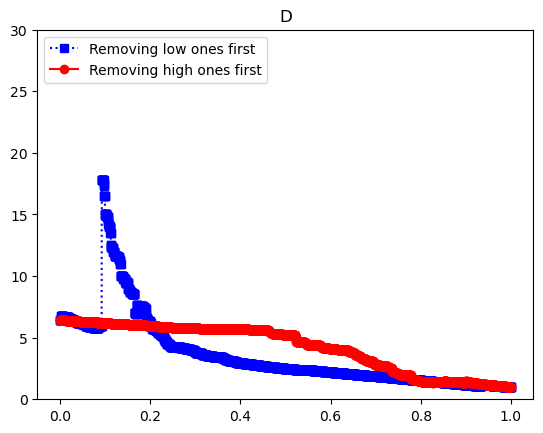

In [25]:
ax = plt.axes()
ax_asc = ax.plot(f_list_d_asc, S_d_asc, 'bs:')
ax_desc = ax.plot(f_list_d_desc, S_d_desc, 'ro-')  
ax.legend(labels = ('Removing low ones first',  
                    'Removing high ones first'),  
          loc = 'upper left') 
  
ax.set_title("D") 
plt.ylim((0,30))
  
plt.show()

In [26]:
df = pd.DataFrame({'f': f_list_d_asc, 'Low ones first': S_d_asc,'High ones first': S_d_desc})

c:\Users\lilin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(0.0, 30.0)

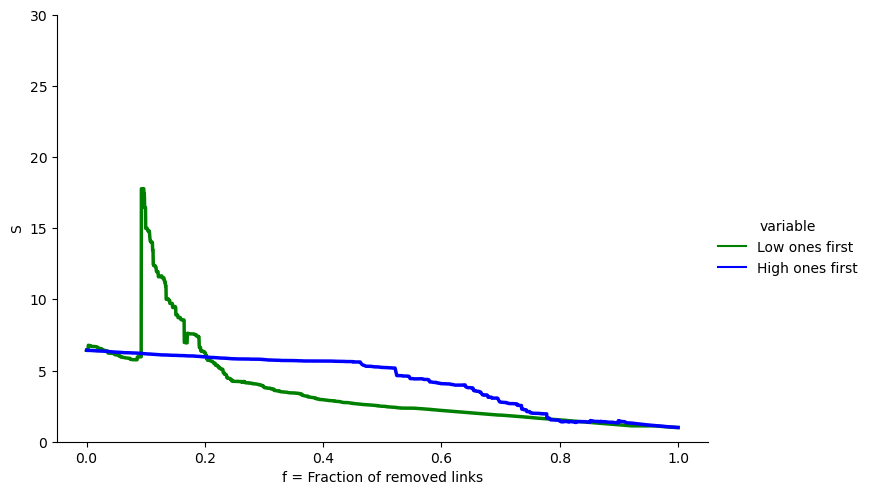

In [27]:
g = sns.relplot(data=pd.melt(df, ['f']), x="f", y="value", kind="line", hue="variable", palette=["g", "b"], linewidth=2.5, aspect=1.5)
g.set_axis_labels("f = Fraction of removed links", "S")
plt.ylim(0, 30)